In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
import torchvision.transforms as transforms

import torch.optim as optim

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.4.0  Device: cuda


In [3]:
batch_size = 20

train_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [4]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([20, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([20]) type: torch.LongTensor


Label: 6


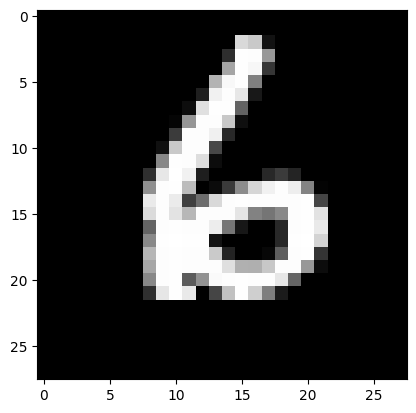

In [5]:
import matplotlib.pyplot as plt
n = 1
# Get the first image from X_train
image = X_train[n]
label = y_train[n]
print('Label:', label.item())

# Reshape the image tensor to 2D
image = image.squeeze().cpu().numpy()

# Display the image
plt.imshow(image, cmap='gray', interpolation='nearest', aspect='equal')
plt.show()

In [6]:
print('X_train:', X_train[0])

X_train: tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [8]:
def init_Kaiming(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_normal_(m.weight.data)
        m.bias.data.fill_(0.01)
        pass

In [9]:
network_const = CNN().to(device)
network_const.apply(init_Kaiming)

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [10]:
def training_epoch(model, train_loader, optimizer, loss_func, epoch):
    train_losses = []
    train_correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        output = model(data)

        loss = loss_func(output, target)
        train_losses.append(loss.item())

        predicted = torch.max(output.data, 1)[1]
        train_correct += (predicted == target).sum()

        loss.backward()

        optimizer.step()

        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    return train_losses, train_correct

In [11]:
def test_epoch(model, test_loader, loss_func):
    correct = 0
    test_losses = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            loss = loss_func(output, target)
            test_losses.append(loss.item())

            predicted = torch.max(output.data, 1)[1]
            correct += (predicted == target).sum()

        test_accuracy = 100. * correct / len(test_loader.dataset)

        print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'
              .format(correct, len(test_loader.dataset), test_accuracy))

    return test_losses, test_accuracy

In [12]:
def training(network):

    learning_rate = 0.01
    epoches = 5

    optimizer = optim.Adam(network.parameters(), lr=learning_rate)
    loss_func = nn.CrossEntropyLoss()

    train_losses_per_epoch = []
    test_losses_per_epoch = []
    
    train_accuracies = []
    test_accuracies = []
   
    for epoch in range(epoches):

        network.train()

        train_losses, train_correct = training_epoch(network, train_loader, optimizer, loss_func, epoch)
        train_losses_per_epoch.append(train_losses)

        train_accuracy = 100. * train_correct / len(train_loader.dataset)
        train_accuracies.append(train_accuracy)

        print('Epoch: {} - Train set: Accuracy: {}/{} ({:.0f}%)'
              .format(epoch, train_correct, len(train_loader.dataset), train_accuracy))

        network.eval()
        with torch.no_grad():
            test_losses, test_accuracy = test_epoch(network, test_loader, loss_func)

        test_losses_per_epoch.append(test_losses)
        test_accuracies.append(test_accuracy)

    return train_losses_per_epoch, test_losses_per_epoch, train_accuracies, test_accuracies

In [46]:
rlt_const = training(network_const)
torch.save(network_const.state_dict(), 'mnist_cnn_const.pt')

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.341518
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.039144
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.126570
Epoch: 0 - Train set: Accuracy: 56714/60000 (95%)

Test set: Accuracy: 9667/10000 (97%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.145347
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.012327
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.084086
Epoch: 1 - Train set: Accuracy: 57980/60000 (97%)

Test set: Accuracy: 9635/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.026676
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.123325
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.007516
Epoch: 2 - Train set: Accuracy: 58217/60000 (97%)

Test set: Accuracy: 9650/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.019826
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.000080
Train Epoch: 3 [40000/60000 (67%)]	Loss: 1.331633
Epoch: 3 - Train set: Accuracy: 58277/60000 (97%)

Test set: Accuracy: 9764/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.004142
Train Epoch: 4 [200

In [13]:
def testing(network):
    network.eval()
    loss_func = nn.CrossEntropyLoss()
    with torch.no_grad():
        test_losses, test_accuracy = test_epoch(network, test_loader, loss_func)

    return test_losses, test_accuracy

In [15]:
network_const.load_state_dict(torch.load('mnist_cnn_const.pt'))
const_test = testing(network_const)

C:\Users\eodbs\AppData\Local\Temp\ipykernel_20256\4209155824.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  network_const.load_state_dict(torch.load('mnist_cnn_const.pt


Test set: Accuracy: 9783/10000 (98%)

